<a href="https://colab.research.google.com/github/varun-kovelamudi/Face-Mask-Detection/blob/main/CNN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 27 21:14:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   47C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import shutil
import os


dataset_path = r"/content/drive/MyDrive/FMD_DATASET"
# Define the categories
categories = ['without_mask',
              'with_mask']

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split



# Define paths for train and test directories
train_dir = "/content/train"
test_dir = "/content/test"

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Splitting the dataset into training and testing sets (e.g., 80% train, 20% test)
image_files = os.listdir(dataset_path)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move training images to the train directory
for filename in train_files:
    src = os.path.join(dataset_path, filename)
    dst = os.path.join(train_dir, filename)
    shutil.copy(src, dst)

# Move testing images to the test directory
for filename in test_files:
    src = os.path.join(dataset_path, filename)
    dst = os.path.join(test_dir, filename)
    shutil.copy(src, dst)


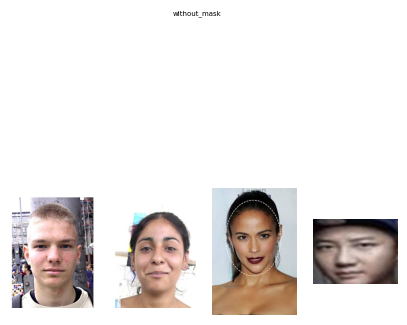

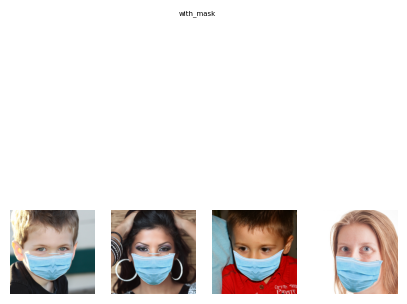

In [ ]:
# Function to plot images
def plot_images(image_dir, category, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    fig.suptitle(category, fontsize=5)

    for i, file_name in enumerate(os.listdir(image_dir)[:num_images]):
        img_path = os.path.join(image_dir, file_name)
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Plot a few images from each category
for category in categories:
    image_dir = os.path.join(dataset_path, category, 'simple')
    plot_images(image_dir, category)

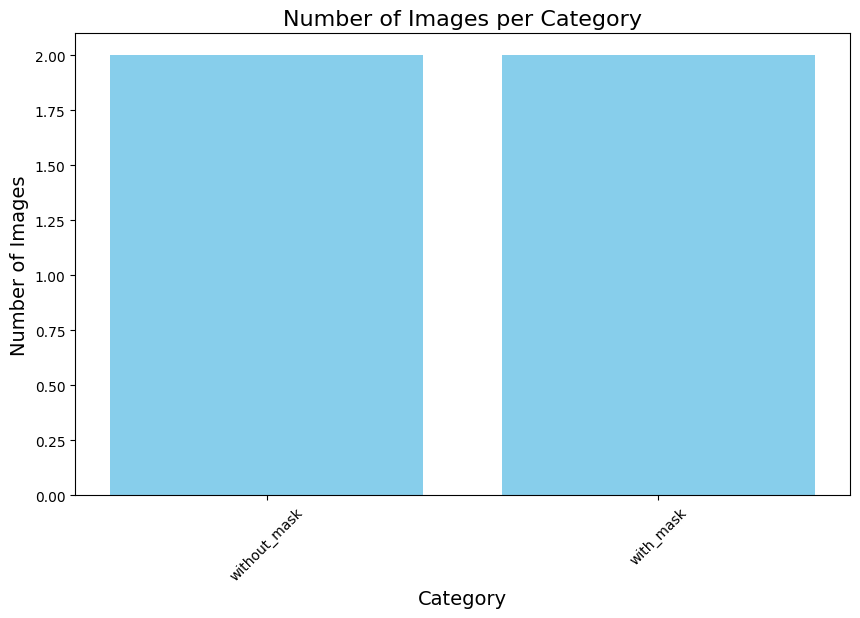

In [ ]:
# Function to count images in each category and plot a bar graph
def plot_category_counts(dataset_path, categories):
    # Lists to store category names and image counts
    category_names = []
    image_counts = []

    # Iterate over each category to count the images
    for category in categories:
        image_dir = os.path.join(dataset_path, category)
        num_images = len(os.listdir(image_dir))

        category_names.append(category)
        image_counts.append(num_images)

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(category_names, image_counts, color='skyblue')
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Number of Images per Category', fontsize=16)
    plt.xticks(rotation=45)  # Rotate category names for better readability
    plt.show()

# Now, call the function with your dataset path and categories
plot_category_counts(dataset_path, categories)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(320, 320),
    batch_size=32,
    class_mode='binary',  # Adjusted for binary classification
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(320, 320),
    batch_size=32,
    class_mode='binary',  # Adjusted for binary classification
    subset='validation'
)

Found 7646 images belonging to 2 classes.
Found 1910 images belonging to 2 classes.


In [ ]:
# Accessing class_indices attribute
class_indices = validation_generator.class_indices

# Getting class names from the class_indices dictionary
class_names = list(class_indices.keys())

# Printing class names
print("Class names in the training generator:")
for name in class_names:
    print(name)

Class names in the training generator:
with_mask
without_mask


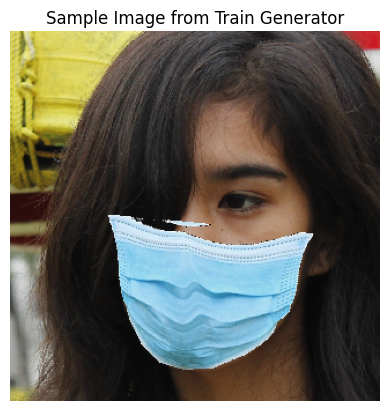

Label for this image: 0.0


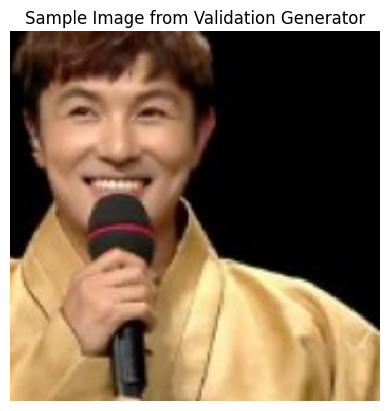

Label for this image: 1.0


In [ ]:
# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Plot the first image in the batch
plt.imshow(images[0])
plt.title("Sample Image from Train Generator")
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# If you also want to display the label for this image
print("Label for this image:", labels[0])


# Get a batch of images and labels from the train_generator
images, labels = next(validation_generator)

# Plot the first image in the batch
plt.imshow(images[0])
plt.title("Sample Image from Validation Generator")
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# If you also want to display the label for this image
print("Label for this image:", labels[0])

In [ ]:
# Define the CNN model for binary classification
model = Sequential([
    tensorflow.keras.Input(shape=(320, 320, 3)),  # Change to 3 for RGB or 1 for grayscale
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Use binary_crossentropy for a binary classification problem
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_generator.n

7646

In [ ]:
#Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Configure model checkpointing
model_checkpoint = ModelCheckpoint(
    r'/content/drive/MyDrive/MaskDetection/best_cnnbasic_model',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]  # Add model_checkpoint here
)

# Save the final model
model.save(r'/content/drive/MyDrive/MaskDetection/cnnbasic_model_final')

Epoch 1/100
191/200 [===========================>..] - ETA: 1:57 - loss: 0.2424 - accuracy: 0.9406

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 3068s 15s/step - loss: 0.2341 - accuracy: 0.9425 - val_loss: 1.5498 - val_accuracy: 0.6562
Epoch 2/100
171/200 [========================>.....] - ETA: 1:03 - loss: 0.0977 - accuracy: 0.9711

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 453s 2s/step - loss: 0.0942 - accuracy: 0.9726 - val_loss: 1.3924 - val_accuracy: 0.6849
Epoch 3/100
192/200 [===========================>..] - ETA: 4s - loss: 0.0761 - accuracy: 0.9772

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 118s 588ms/step - loss: 0.0751 - accuracy: 0.9778 - val_loss: 1.2072 - val_accuracy: 0.6774
Epoch 4/100
 91/200 [============>.................] - ETA: 35s - loss: 0.0766 - accuracy: 0.9736

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 72s 358ms/step - loss: 0.0617 - accuracy: 0.9786 - val_loss: 1.4534 - val_accuracy: 0.7007
Epoch 5/100
200/200 [==============================] - 56s 278ms/step - loss: 0.0445 - accuracy: 0.9844 - val_loss: 1.4609 - val_accuracy: 0.6811
Epoch 6/100
200/200 [==============================] - 53s 263ms/step - loss: 0.0448 - accuracy: 0.9869 - val_loss: 1.9366 - val_accuracy: 0.6875
Epoch 7/100
200/200 [==============================] - 54s 269ms/step - loss: 0.0348 - accuracy: 0.9878 - val_loss: 1.8910 - val_accuracy: 0.6917
Epoch 8/100
200/200 [==============================] - 54s 269ms/step - loss: 0.0360 - accuracy: 0.9906 - val_loss: 1.6307 - val_accuracy: 0.7140
